# Лабораторная работа №2

**Многоклассовый стохастический градиентный спуск**

Вначале просто сделаем нужные нам функции.

In [1]:
from matplotlib import pyplot, mlab
import numpy
import copy
import math
from scipy.optimize import minimize_scalar
import copy

In [2]:
def create_batch(groups, batch_size, features_number, data_for_learning_size, step_num):
    X = []
    Y = []
    elems_from_group = max(1, batch_size // len(groups))
    for i in range(len(groups)):
        for j in range(step_num * elems_from_group, step_num * elems_from_group + elems_from_group):
            X.append(groups[i][j % data_for_learning_size])
            Y.append(i)
    X = numpy.array(X)
    return X, Y

In [3]:
def load_data(max_size=5000):
    data = numpy.genfromtxt('train.csv', delimiter=',')
    data = data[1:]
    groups = [[] for i in range(10)]
    for elem in data:
        if len(elem) != 785:
            print("CRITICAL ERROR: THE PROGRAM CANNOT READ THIS FILE")
            break
        elif int(elem[0]) < len(groups):
            tmp = list(elem[1:])
            tmp.append(1)
            groups[int(elem[0])].append(tmp)
    return groups

Поскольку теперь у нас не вектор весов, а целая матрица, то и градиент у нас будет не вектором, а матрицей производных. Мы ввели ошибку 
$$ Q(W) = -\frac 1l \sum_k \sum_i [y_k = i] \cdot \ln(p_i(Wx^k)), $$ где $p_i(Wx^k) = \frac{\exp(w_i x^k)}{\sum_j \exp(w_j x^k)}$, где $x^k$ - это $k$-й столбец матрицы $X$, $w_i$ - это $i$-я строка матрицы $W$.

Посчитаем $\frac{dQ}{dw_i^j}$. Это равно
$$ -\frac 1l \sum_k \sum_{p\ne i} \left([y_k=p] \frac{\sum_r \exp(w_rx^k)}{\exp(w_px^k)} \cdot \frac{-\exp(w_px^k) \exp(w_i x^k) x_j^k}{(\sum_r \exp(w_rx^k))^2}\right) - 
\frac 1l \sum_k\sum_{p=i} \left([y_k=p] \frac{\sum_r \exp(w_rx^k)}{\exp(w_ix^k)}\cdot \frac{x_j^k\exp (w_ix^k)\sum_r \exp(w_rx^k)-\exp(w_ix^k)\exp(w_ix^k)x_j^k}{\left(\sum_r\exp (w_rx^k)\right)^2}\right) =
$$

$$ = -\frac 1l \sum_k \left(\sum_{p\ne i} \left([y_k=p] (-x_j^k) p_i(Wx^k)\right) + [y_k=i] x_j^k (1-p_i(Wx^k))\right)$$
(просто взяли производную и упростили. Я надеюсь, что читатель справится поверить/проверить.)

Далее заметим, что $x_j^k (1-p_i(Wx^k))$ есть ни что иное как $-x_j^k p_i(Wx^k) + x_j^k$. Тогда вся эта сумма преобразовывается в 
$$
-\frac 1l \sum_k \sum_p \left([y_k=p] ((-x_j^k) p_i(Wx^k) + x_j^k \cdot [y_k=i])\right)
$$
Тогда матрица градиента будет равна
$$
\frac 1l X \cdot (p(WX)-\delta),$$
где $\delta$ - матрица, в $i$-й строке которой стоит 1 в $j$-м столбец тогда и только тогда, когда $i$-й элемент выборки соответствует классу $j$.

Примечание: я тут мог что-то напутать, т.к. уже совсем запутался с тем, что лежит в строке, а что в столбце. У меня в программе на самом деле в элементы выборки лежат в строках.

Также реализованы регуляризаторы, однако мне не удалось добиться того, чтобы они хоть как-то влияли на результаты обучения в лучшую сторону.

In [4]:
def softmax(x):
    e_x = numpy.exp(x - numpy.max(x))
    return e_x / e_x.sum()


def softmax_matrix(X):
    for i in range(len(X)):
        X[i] = softmax(X[i])
    return X


def calculate_loss(W, X, Y, reg_coeff_1=0, reg_coeff_2=0):
    ans = 0
    for x, y in zip(X, Y):
        w = W[y]
        probabilities = softmax(numpy.dot(x, W.T))
        ans += math.log(probabilities[y])
    ans *= (-1 / len(X))
    reg_sum_1 = 0
    reg_sum_2 = 0
    for w in W:
        for elem in w:
            reg_sum_1 += abs(elem)
            reg_sum_2 += elem**2
    return ans + reg_coeff_1 * reg_sum_1 + reg_coeff_2 * reg_sum_2


def calculate_loss_gradient(W, X, Y, reg_coeff_1=0, reg_coeff_2=0):
    gradient = numpy.zeros((len(W), len(W[0])))
    delta = numpy.zeros((len(X), len(W)))
    for k in range(len(X)):
        delta[k][Y[k]] = 1
    gradient = numpy.dot((softmax_matrix(numpy.dot(X, W.T)) - delta).T, X)
    gradient /= len(X)
    gradient += reg_coeff_2 * 2 * W
    for i in range(len(gradient)):
        for j in range(len(gradient[i])):
            if W[i][j] > 0:
                gradient[i][j] += reg_coeff_1
            else:
                gradient[i][j] -= reg_coeff_1
    return gradient


def calculate_next_loss(learning_rate, W, X, Y, gradient, reg_coeff_1=0, reg_coeff_2=0): #for minimize_scalar
    next_W = W - learning_rate * gradient
    return calculate_loss(next_W, X, Y, reg_coeff_1, reg_coeff_2)


def get_number_errors(W, groups):
    ans = 0
    for y in range(0, len(groups)):
        for x in groups[y]:
            algo_ans = softmax(numpy.dot(x, W.T))
            max_val = algo_ans[0]
            best_ind = 0
            for i in range(1, len(algo_ans)):
                if max_val < algo_ans[i]:
                    best_ind = i
                    max_val = algo_ans[i]
            ans += int(best_ind != y)
    return ans

In [5]:
def stohastic_gradient_descent(groups, batch_size, max_number_steps,
                              features_number, data_for_learning_size, min_error,
                              deceleration=0.93, acceleration=1.1, learning_rate=0.000005,
                              reg_coeff_1=0, reg_coeff_2=0):
    list_errors = []
    steps = 0
    W = numpy.zeros((len(groups), features_number))
    general_error = min_error + 1 #this value allows us to execute 'while' below at least 1 time
    while steps < max_number_steps and general_error > min_error: 
        X, Y = create_batch(groups, batch_size, features_number, data_for_learning_size, steps)
        
        gradient = calculate_loss_gradient(W, X, Y, reg_coeff_1, reg_coeff_2)
        #if calculate_next_loss(learning_rate, W, X, Y, gradient, reg_coeff_1, reg_coeff_2) > calculate_loss(W, X, Y, reg_coeff_1, reg_coeff_2):
        #    learning_rate *= deceleration
        W -= learning_rate * gradient
        steps += 1
        #general_error = get_number_errors(W, groups)
        list_errors.append(calculate_loss(W, X, Y, reg_coeff_1, reg_coeff_2))
        #print(" le: ", calculate_loss(W, X, Y), " lr: ", learning_rate, ", ", steps, "%", sep = '')
    return W, list_errors

In [6]:
groups = load_data()
for elem in groups:
    print(len(elem))

4132
4684
4177
4351
4072
3795
4137
4401
4063
4188


Ниже мы в цикле проверяем для различных значений коэффициентов в регуляризаторах, какое качество обучения будет. Выводится график изменения ошибки для лучшего значения.

Batch size:  200
Elements for learning: 20000/42000
lambda1:  0 ; lambda2:  0 ; accuracy:  0.1045
lambda1:  0 ; lambda2:  0.05 ; accuracy:  0.1045
lambda1:  0 ; lambda2:  0.1 ; accuracy:  0.1045
lambda1:  0 ; lambda2:  0.2 ; accuracy:  0.1045
lambda1:  0.01 ; lambda2:  0 ; accuracy:  0.10468181818181818
lambda1:  0.01 ; lambda2:  0.05 ; accuracy:  0.10468181818181818
lambda1:  0.01 ; lambda2:  0.1 ; accuracy:  0.10468181818181818
lambda1:  0.01 ; lambda2:  0.2 ; accuracy:  0.10468181818181818
lambda1:  0.02 ; lambda2:  0 ; accuracy:  0.1050909090909091
lambda1:  0.02 ; lambda2:  0.05 ; accuracy:  0.10504545454545454
lambda1:  0.02 ; lambda2:  0.1 ; accuracy:  0.10504545454545454
lambda1:  0.02 ; lambda2:  0.2 ; accuracy:  0.10504545454545454
lambda1:  0.04 ; lambda2:  0 ; accuracy:  0.10577272727272727
lambda1:  0.04 ; lambda2:  0.05 ; accuracy:  0.10577272727272727
lambda1:  0.04 ; lambda2:  0.1 ; accuracy:  0.10572727272727273
lambda1:  0.04 ; lambda2:  0.2 ; accuracy:  0.10572727272

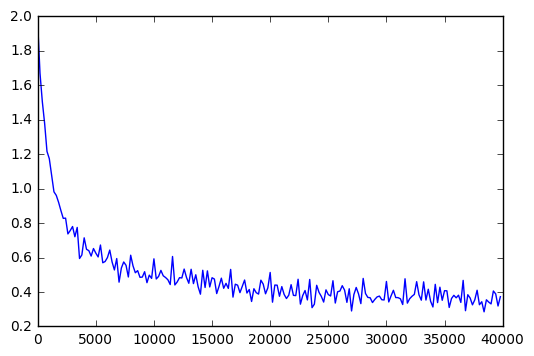

In [9]:
list_results = []
FEATURES_NUMBER = len(groups[0][0])
DATA_FOR_LEARNING_SIZE = 2000 #from every group
MIN_ERROR = 20
EPS = 0.0001
BATCH_SIZE = 200
STEPS = 200
print("Batch size: ", BATCH_SIZE)
print("Elements for learning:", DATA_FOR_LEARNING_SIZE * len(groups), end = "/")
number_elems = 0
for group in groups:
    number_elems += len(group)
print(number_elems)
list_errors = []
best_list_errors = []
best_res = number_elems
best_coeffs = (0, 0)
check_groups = copy.copy(groups)
number_elems = 0
for i in range(len(groups)):
    check_groups[i] = check_groups[i][DATA_FOR_LEARNING_SIZE:]
    number_elems += len(check_groups[i])
for reg_coeff_1 in [0, 0.01, 0.02, 0.04]:
    for reg_coeff_2 in [0, 0.05, 0.1, 0.2]:
        w, list_errors = stohastic_gradient_descent(groups=groups, 
                                                    batch_size=BATCH_SIZE,
                                                    max_number_steps=STEPS,
                                                    features_number=FEATURES_NUMBER, 
                                                    data_for_learning_size=DATA_FOR_LEARNING_SIZE, 
                                                    min_error=MIN_ERROR, 
                                                    reg_coeff_1=reg_coeff_1, 
                                                    reg_coeff_2=reg_coeff_2)
        res = get_number_errors(w, check_groups)
        if best_res > res:
            best_res = res
            best_list_errors = list_errors
            best_coeffs = (reg_coeff_1, reg_coeff_2)
        print("lambda1: ", reg_coeff_1, "; lambda2: ", reg_coeff_2, "; accuracy: ", res / number_elems)

print("Steps: ", STEPS)
print("Errors: ", best_res, "/", number_elems)
print("Used elements: ", min(DATA_FOR_LEARNING_SIZE * len(groups), len(best_list_errors) * BATCH_SIZE))
pyplot.plot([BATCH_SIZE * j for j in range(len(best_list_errors))], best_list_errors, "blue")
pyplot.show()

_Давайте рассмотрим пример на множестве бинарных функций, $x \in \{0, 1\}^{2}$. Пусть есть модель
$y = \theta(wx + b),$_
_где $\theta$ - функция Хевисайда._

**_Задание_**

_1) Предложите значения $w$ и $b$, чтобы $y$ реализовала операторы and, or._

_2) Приведите пример булевой функции, которая не может быть представлена в виде $y$._

Возьмем $w = (0.9\ 0.9), b = -1$. Тогда $wx + b >= 0$ тогда и только тогда, когда $x = (1\ 1)$. Значит, при таких $w, b$ функция $y$ задает оператор $and$.

Возьмем $w = (2\ 2), b = -1$. Тогда $wx + b >= 0$ тогда и только тогда, когда $x \ne (0\ 0)$. Значит, при таких $w, b$ функция $y$ задает оператор $or$.

Возьмем оператор $\oplus$, пусть он представляется функцией $y$. Тогда

$b < 0$ (при $x = (0\ 0)$ функция, равная $\theta(wx + b)=\theta(b)$ должна вернуть 0);

$w_1 + b >= 0; w_2 + b >= 0$ (при $x=(1\ 0)$ или $(0\ 1)$ функция должна возвращать 1);

$w_1 + w_2 + b < 0$.

Но очевидно, что эта система несовместна. Значит, нельзя представить операцию $\oplus$ с помощью $y$.

_Давайте рассмотрим случай посложнее, пусть теперь $x \in \{0, 1\}^{n}$, $y = \theta(W_2 \cdot \theta(W_1x + b_1) + b_2)$, где функция $\theta$ для вектора применяется поэлементно. Кстати, судя по размерности, $W_2$ - вектор, но для общности записан с большой буквы._

_**Задание**_

_1) Можете ли вы теперь представить вашу функцию в виде $y$?_

_2) Может ли $y$ реализовать произвольную булеву функцию?_

Сначала заметим, что выше мы с помощью $\theta(W_2 z + b)$ научились находить $and(z)$ и $or(z)$ (я указал для двух элементов, но для большого количества делается аналогично: например, чтобы сделать $and(x_1, x_2, \ldots, x_n)$, надо выставить значения $w_1, \ldots, w_n$ равными $n^{-1}$, $b=1-\epsilon$).

Также из этого следует, что мы можем находить $\neg and(z)$ и $\neg or(z)$ (надо просто инвертировать знаки $w, b$, тогда значение $\theta$ тоже инвертируется). При желании можно получать отрицания переменной с номером $k$, просто подставляя $w_{i\ne k}=0; b = 0; w_k = -1$.

Операция $x_1\oplus x_2$ - это $(x_1 \vee x_2) \wedge \neg(x_1 \wedge x_2)$. А эту формулу мы умеем уже выражать как
$\theta(W_2\cdot \theta(W_1 x + b_1) + b_2)$: просто подставляем в строки матрицы $W_1, W_2$ нужные вектора, полученные в предыд. задании, а так же в $b_1, b_2$.

Любую булеву функцию можно представить в виде ДНФ. ДНФ - это дизъюнция конъюнкций, в которые могут входить отрицания. С помощью $z=\theta(W_1x + b_1)$ можно получить любой набор таких конъюнкций. А дизъюнкцию вектора $z$ мы вычисляем как $y(z)=\theta(W_2 z + b_2)$. Таким образом, мы можем вычислить любую формулу.

**Реализация полносвязной двуслойной сети**

Видно, что для двуслойной сети за такое же количество эпох мы имеем лучшее качество. Другое дело, что и обучение длится в 2 раза дольше.

In [1]:
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

Using TensorFlow backend.


60000 train samples
10000 test samples


60000 train samples
10000 test samples

Layer size: 16
Test score: 0.258854511353
Test accuracy: 0.9267

Layer size: 32
Test score: 0.230705892196
Test accuracy: 0.9335

Layer size: 64
Test score: 0.187577620359
Test accuracy: 0.9466

Layer size: 128
Test score: 0.152562427942
Test accuracy: 0.9517

Layer size: 256
Test score: 0.121266644774
Test accuracy: 0.9637

Layer size: 512
Test score: 0.1080652511
Test accuracy: 0.9664

Layer size: 1024
Test score: 0.086498718244
Test accuracy: 0.9715


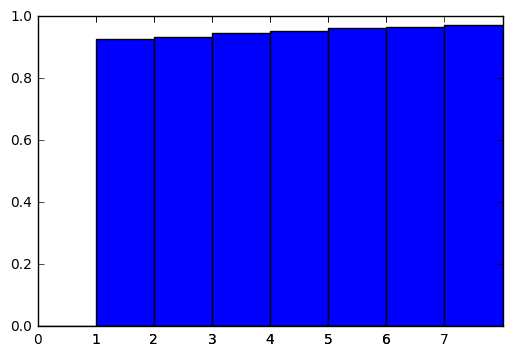

In [157]:
batch_size = 200
nb_classes = 10
nb_epoch = 2

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

LAYER_SIZE = [16, 32, 64, 128, 256, 512, 1024]
list_accuracy = []
for layer_size in LAYER_SIZE:
    print()
    print("Layer size:", layer_size)
    model = Sequential()
    model.add(Dense(layer_size, input_shape=(784,)))
    model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])
    history = model.fit(X_train, Y_train,
                        batch_size=batch_size, nb_epoch=nb_epoch,
                        verbose=0, validation_data=(X_test, Y_test))
    score = model.evaluate(X_test, Y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])
    list_accuracy.append(score[1])
y_bar = [0] * len(list_accuracy) * 2
x_bar = [0] * len(list_accuracy) * 2
for i in range(len(list_accuracy)):
    y_bar[i * 2] = 0
    y_bar[i * 2 + 1] = list_accuracy[i]
    x_bar[i * 2] = i
    x_bar[i * 2 + 1] = i + 1
pyplot.bar(x_bar, y_bar, 1)
plt.xticks(x_bar)
pyplot.show()

Видно, что с увеличением размера слоя в 2 раза ошибка уменьшается линейно, и с некоторого момента рост замедляется.

Таким образом, не имеет смысла делать размер слоя больше 256 или 512, поскольку качество почти перестает улучшаться.

Ниже приведен алгоритм, который реализует многослойную сеть с небольшими размерами слоев: первый слой имеет размер 256, остальные имеют размер 64, кроме последнего, размер которого равен 10.

Layers:  2
Test score: 0.064050740806
Test accuracy: 0.9819
Layers:  3
Test score: 0.0733169970408
Test accuracy: 0.982
Layers:  4
Test score: 0.0818073636846
Test accuracy: 0.9802
Layers:  5
Test score: 0.0824218913875
Test accuracy: 0.9805
Layers:  6
Test score: 0.0804722498798
Test accuracy: 0.9794
Layers:  7
Test score: 0.0822479630598
Test accuracy: 0.9796
Layers:  8
Test score: 0.104052912133
Test accuracy: 0.9764
Layers:  9
Test score: 0.125866291558
Test accuracy: 0.9777


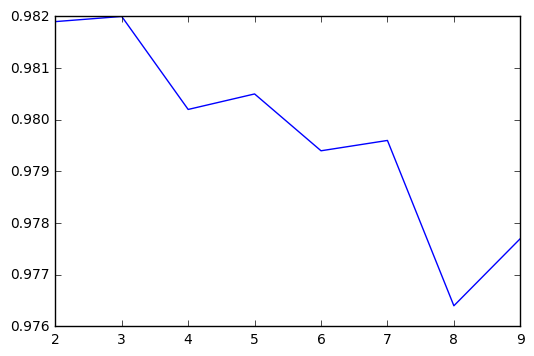

In [12]:
batch_size = 128
nb_classes = 10
nb_epoch = 10

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

list_errors = []

for layers in range(2, 10):
    print("Layers: ", layers)
    model = Sequential()
    model.add(Dense(256, input_shape=(784,)))
    model.add(Dropout(0.1))
    model.add(Activation('relu'))
    for i in range(1, layers - 1):
        model.add(Dense(64))
        model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])

    history = model.fit(X_train, Y_train,
                        batch_size=batch_size, nb_epoch=nb_epoch,
                        verbose=0, validation_data=(X_test, Y_test))
    score = model.evaluate(X_test, Y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])
    list_errors.append(score[1])
pyplot.plot([i + 2 for i in range(len(list_errors))], list_errors, "blue")
pyplot.show()

Видно, что с ростом количества слоев ошибка увеличивается.

Ниже приведен алгоритм, который с помощью автокодировщика обучает сеть из 7 слоев. Первый слой имеет размер 256, слои со 2-го по 5-й обучаются с помощью автокодировщика и имеют размер 64 - $i \cdot 2$, где $i+1=$ номер слоя, слои 6 и 7 обучаются с помощью обычного обучения и имеют размер 52 и 10 соответственно.

In [6]:
batch_size = 128
nb_classes = 10
nb_epoch = 15

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

layers = [
    Dense(256, input_shape=(784,)),
    Activation('relu')
]

y_train_autoencoder = X_train
y_test_autoencoder = X_test
autoencoder_dence = Dense(784, input_shape=(256,))

print("Start learning...")
for layers_number in range(1, 6):
    model = Sequential(layers[-2:] + [autoencoder_dence])
    model.compile(loss='mean_squared_error',
                  optimizer=RMSprop(),
                  metrics=['mean_squared_error'])
    
    history = model.fit(y_train_autoencoder, y_train_autoencoder,
                    batch_size=batch_size, nb_epoch=nb_epoch,
                    verbose=0, validation_data=(y_test_autoencoder, y_test_autoencoder))

    print("Layer №", layers_number, "added")
    print("Accuracy:", model.evaluate(y_test_autoencoder, y_test_autoencoder, verbose=0)[1])
    model = Sequential(layers)
    y_train_autoencoder = model.predict(X_train)
    y_test_autoencoder = model.predict(X_test)
    if layers_number == 1:
        autoencoder_dence = Dense(256, input_shape=(62,))
    else:
        autoencoder_dence = Dense(64 - 2 * layers_number + 2, input_shape=(64-2*layers_number,))
    layers[-2].trainable = False
    layers[-1].trainable = False
    if layers_number != 1:
        layers.append(Dense(64 - 2 * layers_number, input_shape=(64-2*(layers_number-1),)))
    else:
        layers.append(Dense(64 - 2 * layers_number, input_shape=(256,)))
    layers.append(Activation('relu'))
print("All layers added. Learning...")
layers.append(Dense(10))
layers.append(Activation('softmax'))
model = Sequential(layers)
model.compile(loss='categorical_crossentropy',
             optimizer=Adam(),
             metrics=['accuracy'])
    
history = model.fit(X_train, Y_train,
                    batch_size=batch_size, nb_epoch=nb_epoch,
                    verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Start learning...
Layer № 1 added
Accuracy: 0.00621453641355
Layer № 2 added
Accuracy: 0.0181479619712
Layer № 3 added
Accuracy: 0.00819112404585
Layer № 4 added
Accuracy: 0.00705839088485
Layer № 5 added
Accuracy: 0.00709323872626
All layers added. Learning...
Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 7s - loss: 1.1131 - acc: 0.7033 - val_loss: 0.5414 - val_acc: 0.8615
Epoch 2/15
60000/60000 [==============================] - 6s - loss: 0.4668 - acc: 0.8710 - val_loss: 0.3957 - val_acc: 0.8886
Epoch 3/15
60000/60000 [==============================] - 6s - loss: 0.3814 - acc: 0.8911 - val_loss: 0.3454 - val_acc: 0.9013
Epoch 4/15
60000/60000 [==============================] - 6s - loss: 0.3469 - acc: 0.8988 - val_loss: 0.3245 - val_acc: 0.9047
Epoch 5/15
60000/60000 [==============================] - 6s - loss: 0.3262 - acc: 0.9036 - val_loss: 0.3084 - val_acc: 0.9078
Epoch 6/15
60000/60000 [=============================

Видно, что сеть обучается хуже, чем в простом варианте. Мораль: это не панацея. 

С другой стороны, возможно, если по-другому выбирать слои, то возможно будет работать лучше. Данная сеть из 7 слоев построена искусственно: ясно (мне, по крайней мере), что для такой задачи достаточно сети на 3-4 слоя максимум (хотя бы из-за сравнительно небольшого размера выборки). А искусственные вещи обычно работают довольно плохо. 

На самом деле можно заметить, что принцип Autoencoding'а позволяет выделять какие-то признаки, не слишком снижая ошибку. Также в данном внутренние слои можно обучать больше эпох (благо слои довольно небольшие), тогда ошибка на них будет еще меньше.